In [1]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings

warnings.filterwarnings("ignore")

c:\Users\herbe\anaconda3\envs\TS_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("air_passengers.csv").rename(
    columns={"Passengers": "y", "Month": "ds"}
)

### Analisys

In [3]:
df["ds"] = pd.to_datetime(df["ds"])
df["Month"] = df["ds"].dt.month
df["Year"] = df["ds"].dt.year

[Text(0.5, 1.0, 'Boxplot by Month'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Passengers')]

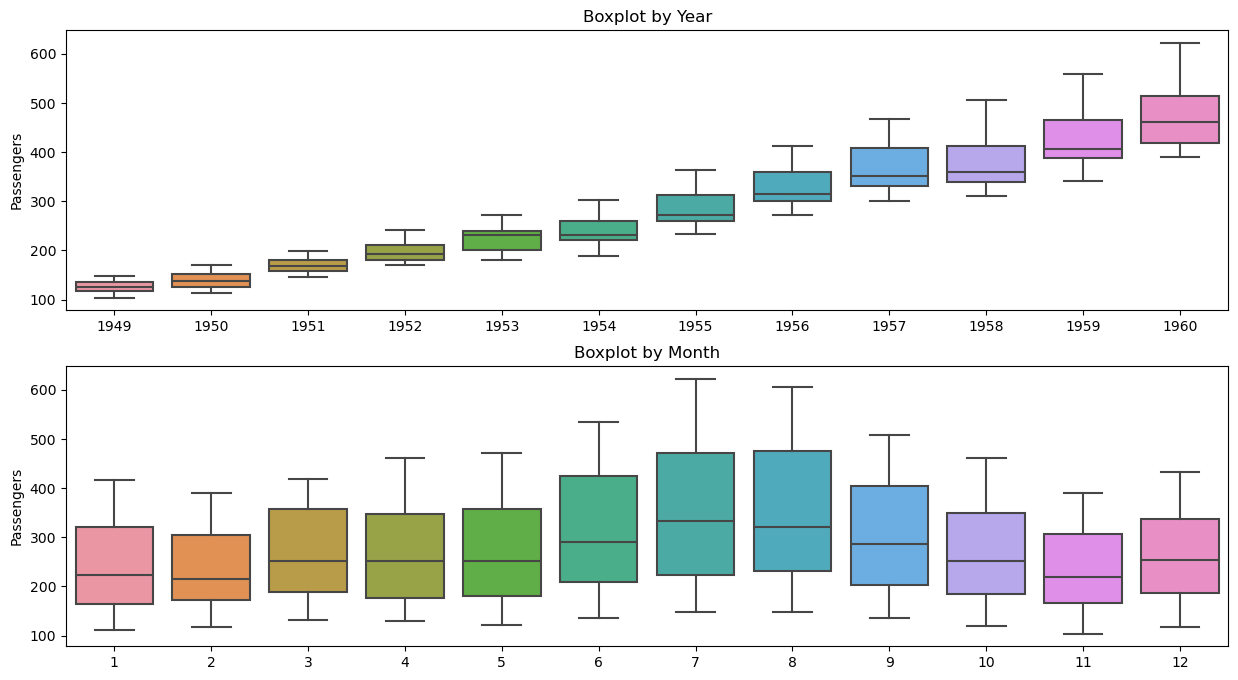

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(15, 4 * 2))
sns.boxplot(x="Year", y="y", data=df, ax=ax[0]).set(
    title="Boxplot by Year", xlabel="", ylabel="Passengers"
)
sns.boxplot(x="Month", y="y", data=df, ax=ax[1]).set(
    title="Boxplot by Month", xlabel="", ylabel="Passengers"
)

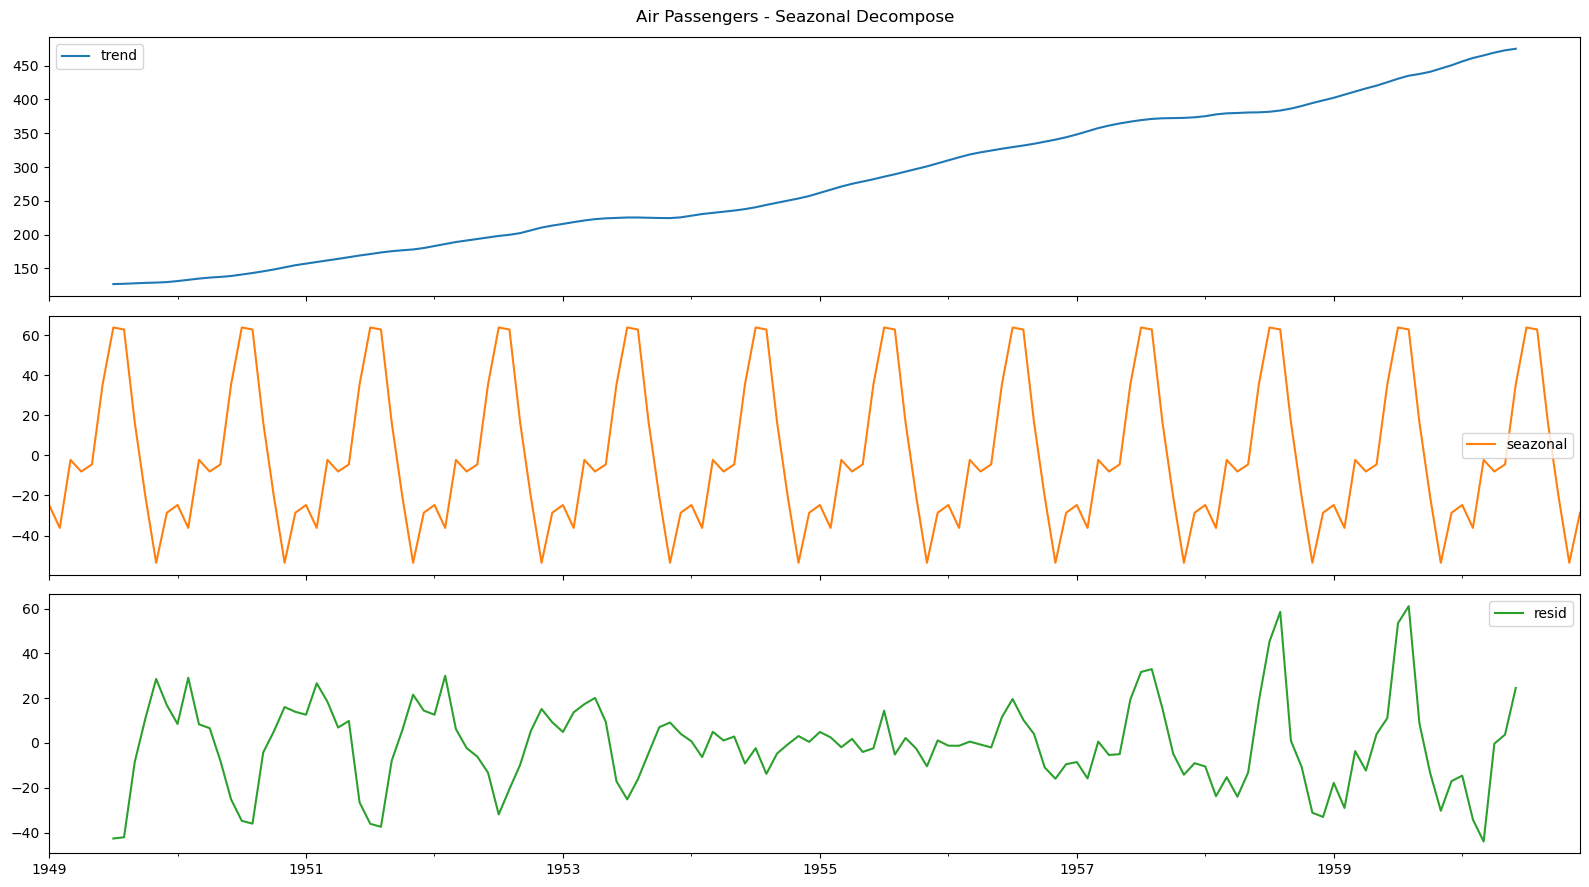

In [5]:
result = seasonal_decompose(df["y"], model="additive", period=12)
df["trend"] = result.trend
df["seazonal"] = result.seasonal
df["resid"] = result.resid

df.plot(
    x="ds",
    y=["trend", "seazonal", "resid"],
    figsize=(16, 3 * 3),
    title="Air Passengers - Seazonal Decompose",
    xlabel="",
    subplots=True,
)
plt.tight_layout()

In [6]:
Q3 = result.resid.quantile(0.75)
Q1 = result.resid.quantile(0.25)
IQR = Q3 - Q1
Limin = Q1 - (IQR * 1.5)
Limsp = Q3 + (IQR * 1.5)
df["outlier"] = np.where((df["resid"] < Limin) | (df["resid"] > Limsp), df["y"], np.nan)

[Text(0.5, 1.0, 'Air Passengers - Outliers'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Passengers')]

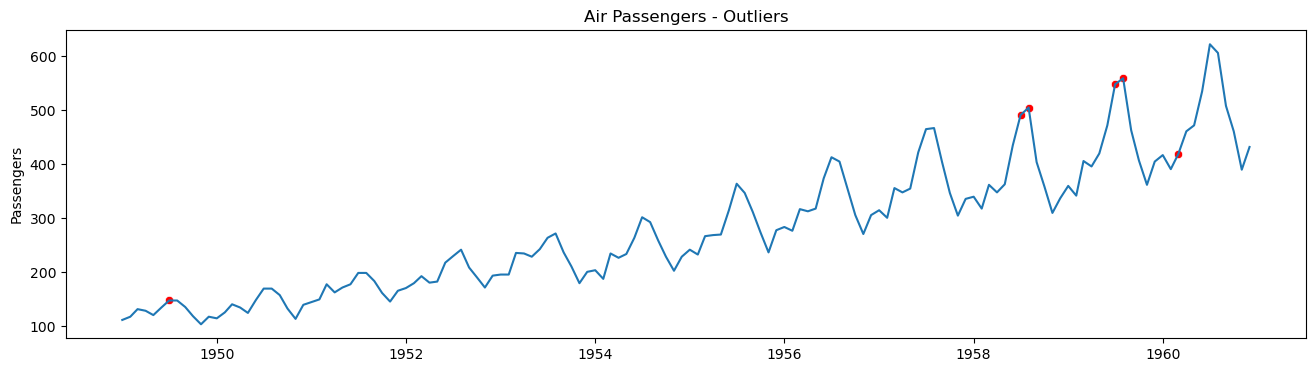

In [7]:
plt.figure(figsize=(16, 4))
sns.scatterplot(x="ds", y="outlier", data=df, color="red")
sns.lineplot(x="ds", y="y", data=df).set(
    title="Air Passengers - Outliers", xlabel="", ylabel="Passengers"
)

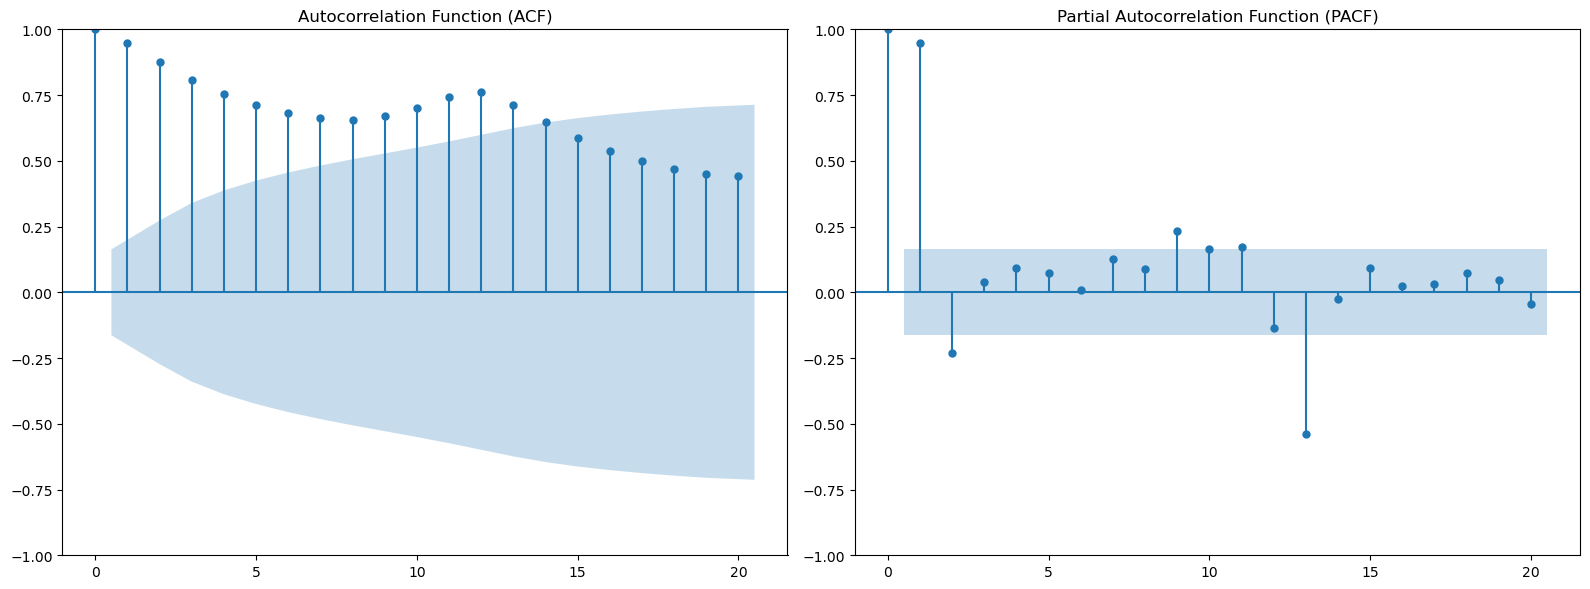

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(df["y"], lags=20, ax=ax1)
ax1.set_title("Autocorrelation Function (ACF)")
plot_pacf(df["y"], lags=20, ax=ax2)
ax2.set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

### Cleaning Data

In [9]:
df["y"] = np.where((df["resid"] < Limin) | (df["resid"] > Limsp), None, df["y"])
df = df[["ds", "y"]]

### Grid Search

In [10]:
param_grid = {
    "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5],
    "seasonality_prior_scale": [0.01, 0.1, 1.0, 10.0],
    "seasonality_mode": ["additive", "multiplicative"],
    "changepoint_range": [0.3, 0.5, 0.7, 0.9],
    "growth": ["linear"],
    "yearly_seasonality": [True],
}

cutoffs = pd.to_datetime(
    [
        "1959-01",
        "1959-02",
        "1959-03",
        "1959-04",
        "1959-05",
        "1959-06",
        "1959-07",
        "1959-08",
        "1959-09",
        "1959-10",
        "1959-11",
        "1959-12",
    ]
)

all_params = [
    dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())
]
results = pd.DataFrame()
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(
        m, horizon="365 days", cutoffs=cutoffs, parallel="processes"
    )
    results = pd.concat([results, df_cv.assign(labeled_params=str(params))], axis=0)

05:26:00 - cmdstanpy - INFO - Chain [1] start processing
05:26:00 - cmdstanpy - INFO - Chain [1] done processing
05:26:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:26:00 - cmdstanpy - INFO - Chain [1] start processing
05:26:01 - cmdstanpy - INFO - Chain [1] done processing
05:26:12 - cmdstanpy - INFO - Chain [1] start processing
05:26:12 - cmdstanpy - INFO - Chain [1] done processing
05:26:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:26:12 - cmdstanpy - INFO - Chain [1] start processing
05:26:13 - cmdstanpy - INFO - Chain [1] done processing
05:26:24 - cmdstanpy - INFO - Chain [1] start processing
05:26:24 - cmdstanpy - INFO - Chain [1] done processing
05:26:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

### Error Metric

In [11]:
results["APE"] = (np.abs(results["y"] - results["yhat"]) / results["y"]) * 100

### Finding The Best !!!

In [12]:
results.groupby(["labeled_params", "cutoff"])[
    "APE"
].mean().sort_values().reset_index().groupby("cutoff").min()["labeled_params"].unique()

array(["{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.3, 'growth': 'linear', 'yearly_seasonality': True}"],
      dtype=object)

In [13]:
best_params = results.groupby(["labeled_params", "cutoff"])["APE"].mean().sort_values().reset_index().groupby("cutoff").min()["labeled_params"].unique()[0]
best_model = results[results["labeled_params"] == best_params]

### MAPE

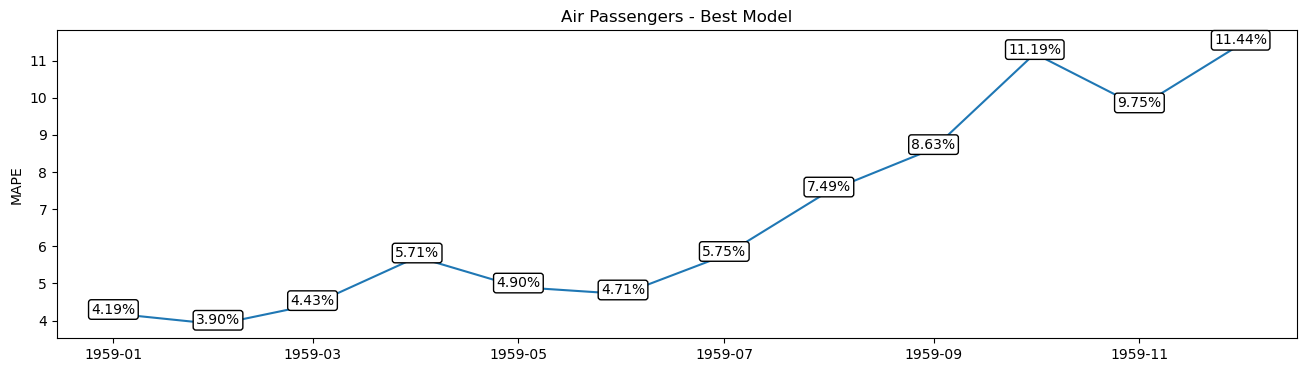

In [14]:
plt.figure(figsize=(16, 4))
sns.lineplot(
    x="cutoff",
    y="APE",
    data=best_model.groupby("cutoff")["APE"].mean().reset_index(),
    marker="o",
).set(title="Air Passengers - Best Model", xlabel="", ylabel="MAPE")

for index, row in best_model.groupby("cutoff")["APE"].mean().reset_index().iterrows():
    plt.annotate(
        f"{row['APE']:.2f}%",
        xy=(row['cutoff'], row['APE']),
        xytext=(row['cutoff'], row['APE']),
        ha='center',
        color='black',
        bbox=dict(boxstyle='round,pad=0.2', fc='white'),
    )
plt.show()


[Text(0.5, 0, ''),
 Text(0, 0.5, 'APE(%)'),
 Text(0.5, 1.0, 'Air Passengers - Best Model - Boxplot by Cutoff')]

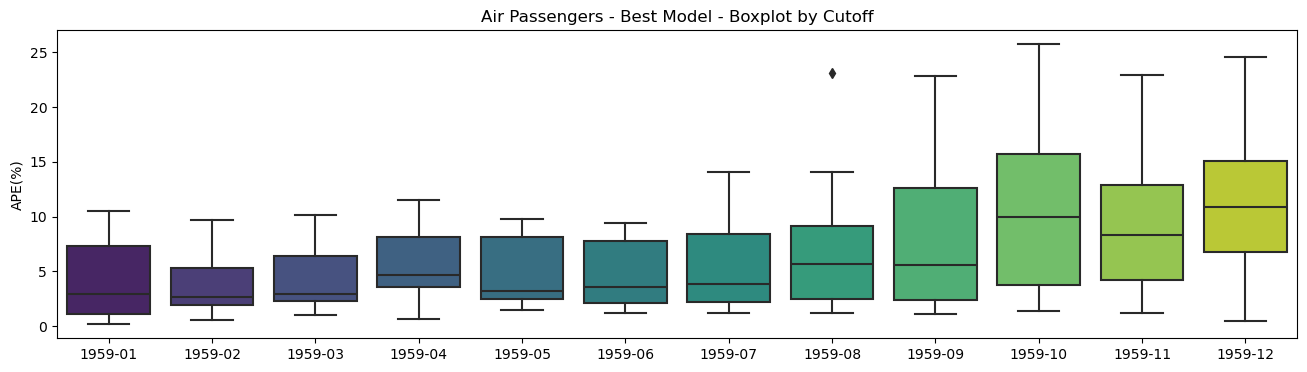

In [15]:
best_model["cutoff"] = pd.to_datetime(best_model["cutoff"]).dt.strftime("%Y-%m")
plt.figure(figsize=(16, 4))
sns.boxplot(x="cutoff", y="APE", data=best_model,palette="viridis").set(xlabel="", ylabel="APE(%)", title="Air Passengers - Best Model - Boxplot by Cutoff")

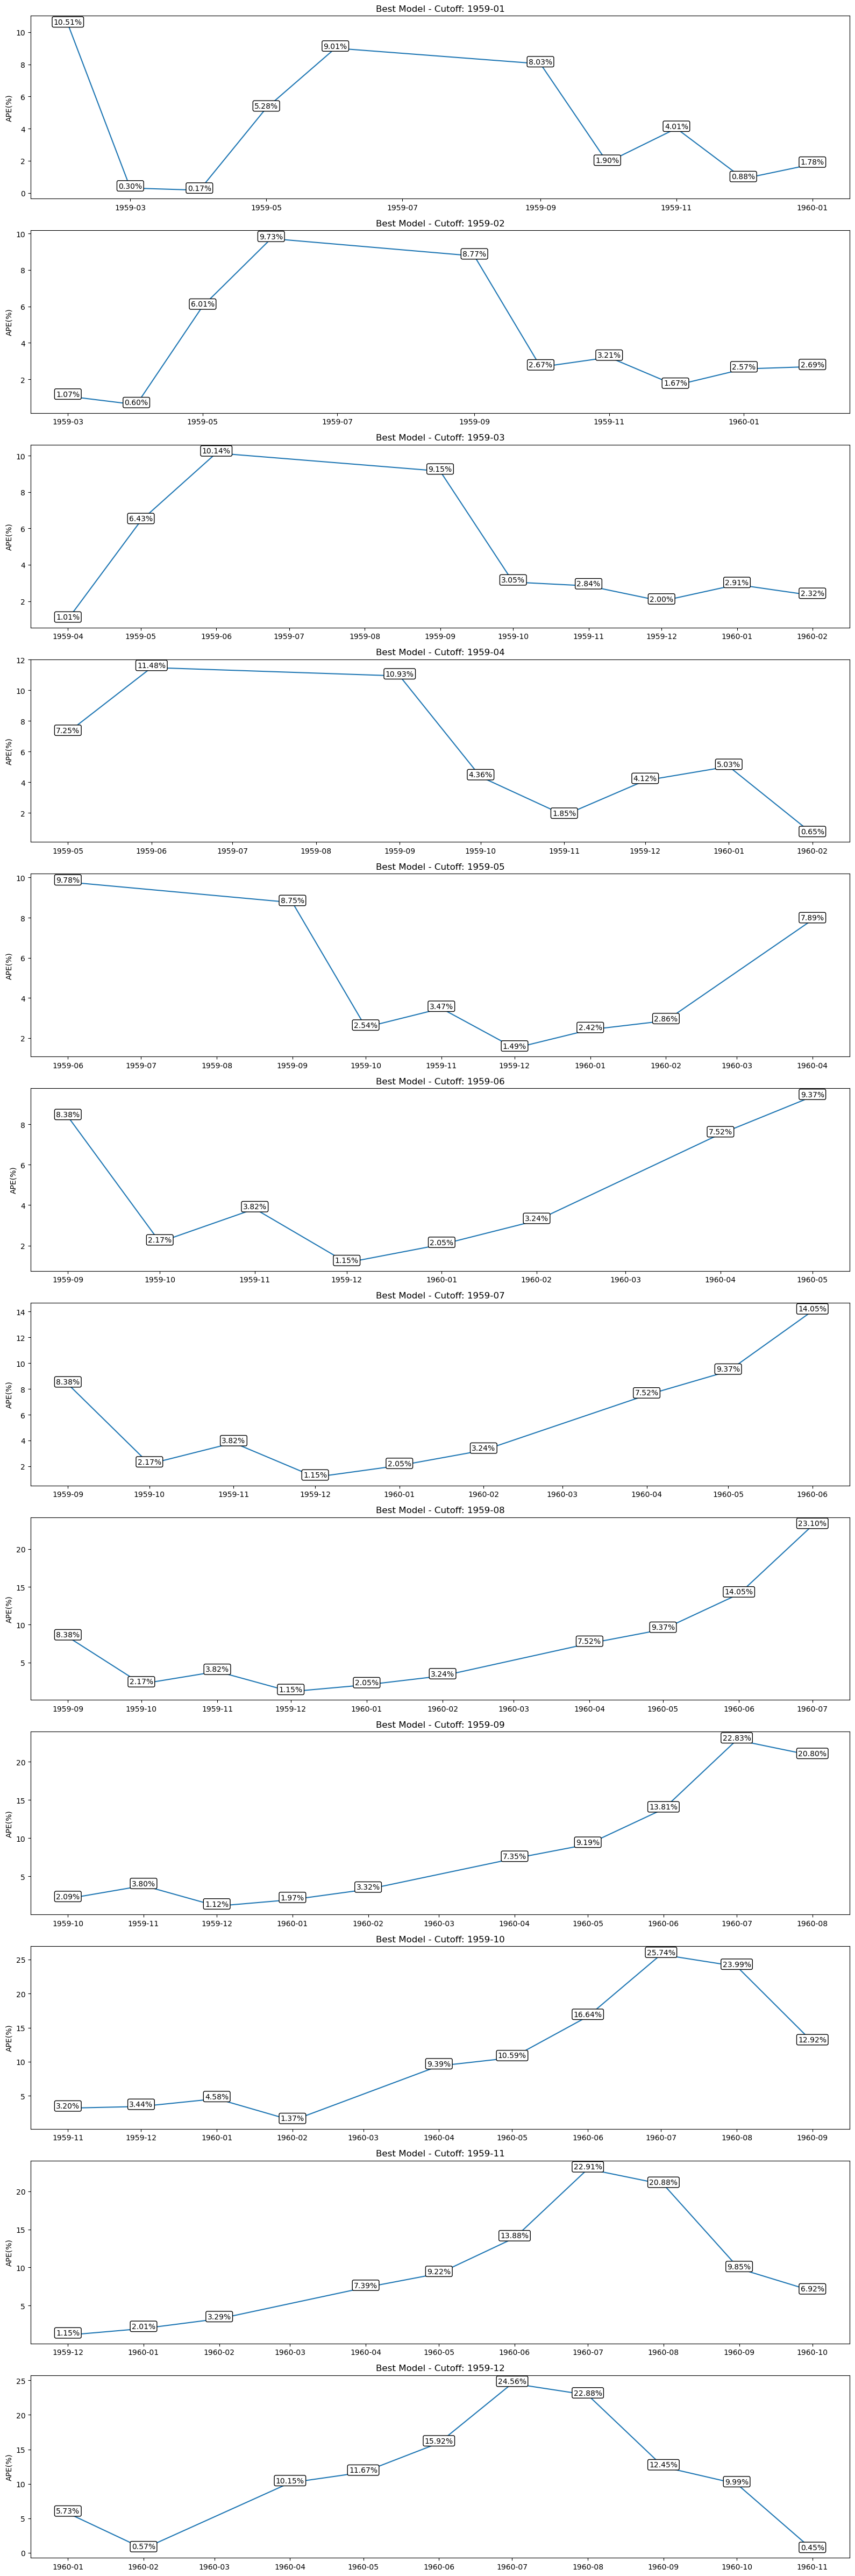

In [16]:
fig, axes = plt.subplots(len(best_model["cutoff"].unique()), 1, figsize=(16, 4 * len(best_model["cutoff"].unique())))

for i, cutoff in enumerate(best_model["cutoff"].unique()):
    ax = axes[i]
    sns.lineplot(x="ds", y="APE", data=best_model[best_model["cutoff"] == cutoff], marker="o", ax=ax)
    ax.set(xlabel="", ylabel="APE(%)", title=f"Best Model - Cutoff: {cutoff}")

    for index, row in best_model[best_model["cutoff"] == cutoff].iterrows():
        ax.annotate(
            f"{row['APE']:.2f}%",
            xy=(row['ds'], row['APE']),
            xytext=(row['ds'], row['APE']),
            ha='center',
            color='black',
            bbox=dict(boxstyle='round,pad=0.2', fc='white'),
        )

plt.tight_layout()